In [1]:
import datetime
import hashlib
import os
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set(style='whitegrid')

# Read in data

In [2]:
# must be run from 'tutorials' directory
# currently only works from the 'artifacts' branch
data_dir = os.path.join(os.path.dirname(os.getcwd()), "tutorial_performance_data")

In [3]:
def read_data(fname: str) -> pd.DataFrame:
    # format is {mode}_{commit_hash}_{date_time}.csv
    mode, commit_hash, date_time = fname[:-4].split("_")
    df = (
        pd.read_csv(os.path.join(data_dir, fname))
        .dropna()
        .assign(
            mode=mode, commit_hash=commit_hash, datetime=pd.to_datetime(date_time),
            fname=fname
        )
    )
    # clean out '.ipynb' if it is present
    df["name"] = df["name"].apply(lambda x: x[:-len('.ipynb')])
    df["n_tutorials_run"] = len(df)
    df["set_of_tutorials_run_hash"] = hash("".join(df['name'].sort_values()))
    df["all_ran_successfully"] = df["ran_successfully"].all()
    return df


In [5]:
df = pd.concat(
    (
        read_data(fname=fname)
        for fname in os.listdir(data_dir)
        if fname != "all_data.csv"
    ),
    ignore_index=True
).sort_values(["mode", "datetime"], ignore_index=True)
df["memory_increase"] = df["max_mem"] - df["start_mem"]
df["short_name"] = df["name"].apply(lambda x: x[:21])

# Plot performance metrics over time

In [6]:
per_hash_data = (
    df.loc[df["all_ran_successfully"], ["mode", "fname", "set_of_tutorials_run_hash"]]
    .drop_duplicates()
    .groupby(["mode", "set_of_tutorials_run_hash"])
    .agg(n_runs = ("fname", "count"))
)
per_hash_data["most_recent_run"] = (
    df[df["all_ran_successfully"]]
    .groupby(["mode", "set_of_tutorials_run_hash"])["datetime"].max()
)
per_hash_data.reset_index(inplace=True)
# loosen this as more data comes in
per_hash_data["keep"] = (
    (per_hash_data["n_runs"] > 0) & (per_hash_data["most_recent_run"] > "2023-02-01")
)
per_hash_data

,mode,set_of_tutorials_run_hash,n_runs,most_recent_run,keep
0,smoke-test,-5803977625217957267,3,2023-02-22 21:46:29.434078,True
1,standard,-920350488208539458,2,2023-02-21 18:31:22.638945,True
2,standard,2153372915312212851,5,2023-02-23 11:25:20.403119,True


In [7]:
time_series_data_wide = (
    df[df["all_ran_successfully"]]
    .groupby(["mode", "set_of_tutorials_run_hash", "fname", "datetime"])
    .agg(
        total_runtime=("runtime", "sum"),
        slowest_runtime=("runtime", "max"),
        avg_memory=("memory_increase", "mean"),
        max_memory=("memory_increase", "max")
    )
)
time_series_data_long = (
    pd.melt(
        time_series_data_wide.reset_index(),
        id_vars=["mode", "set_of_tutorials_run_hash", "fname", "datetime"],
        value_vars=["total_runtime", "slowest_runtime", "avg_memory", "max_memory"],
        var_name="metric"
    ).merge(per_hash_data)
)
time_series_data_long.head()

,mode,set_of_tutorials_run_hash,fname,datetime,metric,value,n_runs,most_recent_run,keep
0,smoke-test,-5803977625217957267,smoke-test_52959e64_2023-02-22 21:46:29.434078...,2023-02-22 21:46:29.434078,total_runtime,1290.205423,3,2023-02-22 21:46:29.434078,True
1,smoke-test,-5803977625217957267,smoke-test_68547512_2023-02-21 20:00:29.634413...,2023-02-21 20:00:29.634413,total_runtime,658.368388,3,2023-02-22 21:46:29.434078,True
2,smoke-test,-5803977625217957267,smoke-test_8db9c7bb_2023-02-22 03:08:53.257852...,2023-02-22 03:08:53.257852,total_runtime,1025.418331,3,2023-02-22 21:46:29.434078,True
3,smoke-test,-5803977625217957267,smoke-test_52959e64_2023-02-22 21:46:29.434078...,2023-02-22 21:46:29.434078,slowest_runtime,294.099438,3,2023-02-22 21:46:29.434078,True
4,smoke-test,-5803977625217957267,smoke-test_68547512_2023-02-21 20:00:29.634413...,2023-02-21 20:00:29.634413,slowest_runtime,166.174323,3,2023-02-22 21:46:29.434078,True


In [8]:
def make_time_series_plot(time_series_data_long: pd.DataFrame, mode: str) -> sns.FacetGrid:
    keep_data = time_series_data_long[
        time_series_data_long["keep"] & (time_series_data_long["mode"] == mode)
    ].sort_values("datetime")
    if len(keep_data) == 0:
        print(f"No {mode} data.")
        return
    g = sns.FacetGrid(
        data=keep_data,
        col="metric",
        col_wrap=2,
        aspect=1.5,
        sharey=False,
        hue="set_of_tutorials_run_hash",
        palette="viridis"
    )
    g.map(plt.plot, "datetime", "value")
    g.map(plt.scatter, "datetime", "value")
    g.add_legend()
    g.fig.suptitle(mode)
    plt.subplots_adjust(top=0.9)
    return g

In [9]:
def make_histogram(time_series_data_long: pd.DataFrame, mode: str) -> sns.FacetGrid:
    if not (per_hash_data["mode"] == mode).any():
        print(f"No relevant {mode} data.")
        return
    most_recent_hash = (
        per_hash_data[per_hash_data["mode"] == mode]
        .sort_values("most_recent_run")
        ["set_of_tutorials_run_hash"]
        .values[-1]
    )
    
    keep_data = time_series_data_long[
        time_series_data_long["keep"] & (time_series_data_long["mode"] == mode)
        & (time_series_data_long["set_of_tutorials_run_hash"] == most_recent_hash)
    ]
    if len(keep_data) == 0:
        print(f"No relevant {mode} data.")
        return
    g = sns.FacetGrid(
        data=keep_data,
        col="metric",
        col_wrap=2,
        aspect=1.5,
        sharex=False
    )
    g.map(plt.hist, "value", color='k')
    g.fig.suptitle(mode)
    plt.subplots_adjust(top=0.9)
    return g

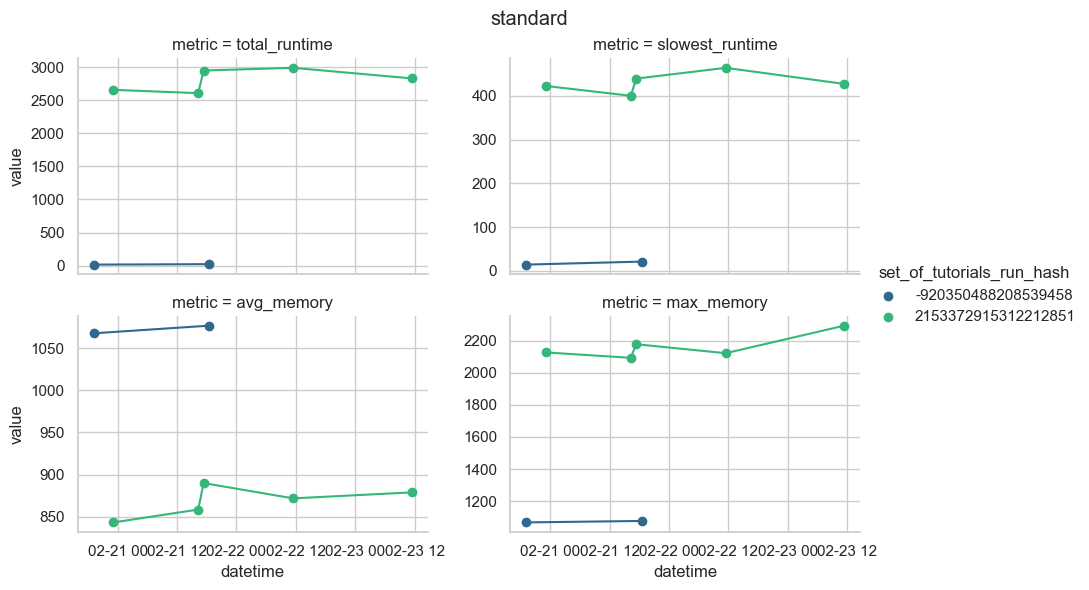

In [10]:
make_time_series_plot(time_series_data_long, "standard")

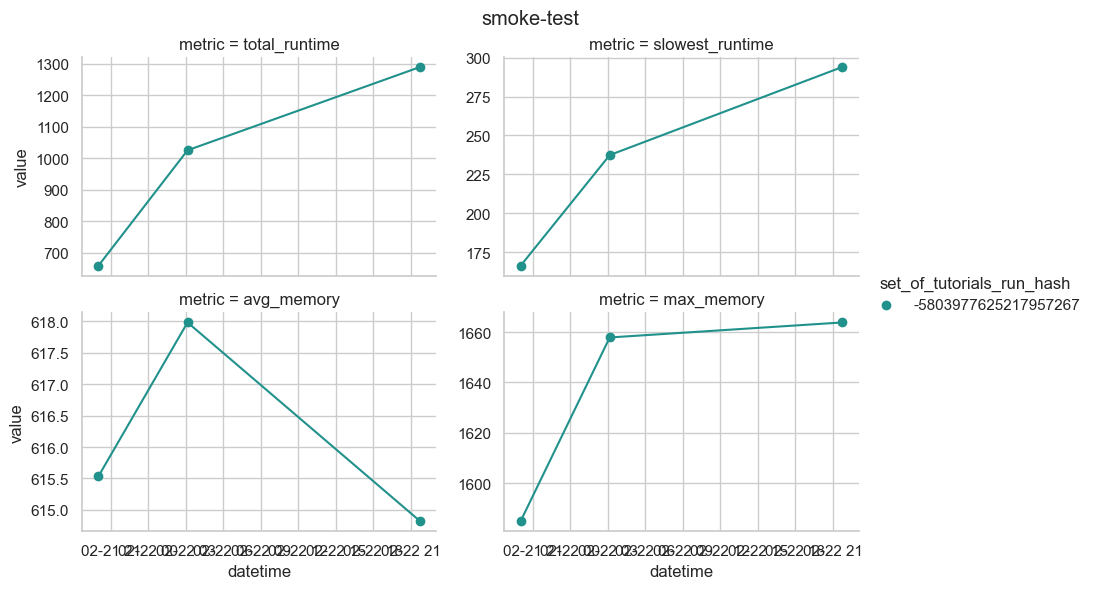

In [11]:
make_time_series_plot(time_series_data_long, "smoke-test")

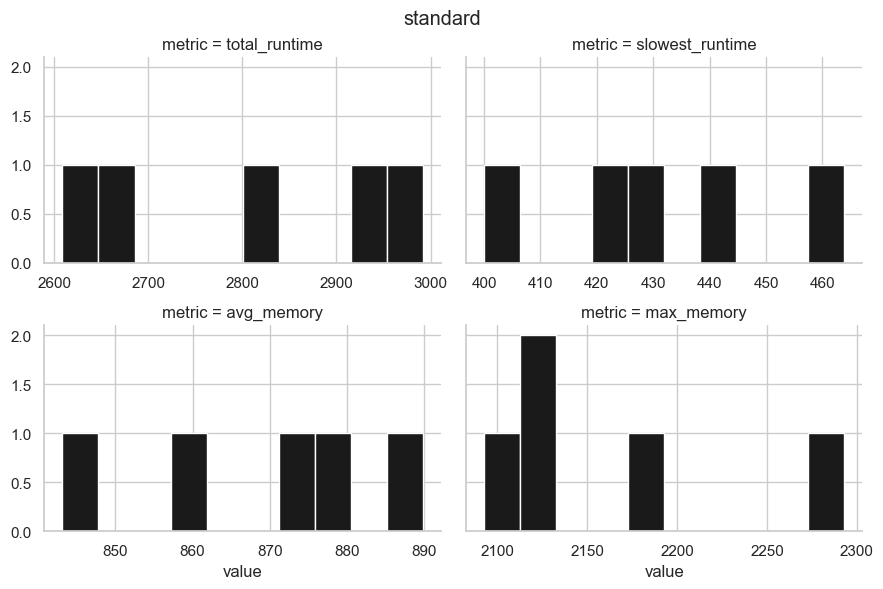

In [12]:
make_histogram(time_series_data_long, "standard")

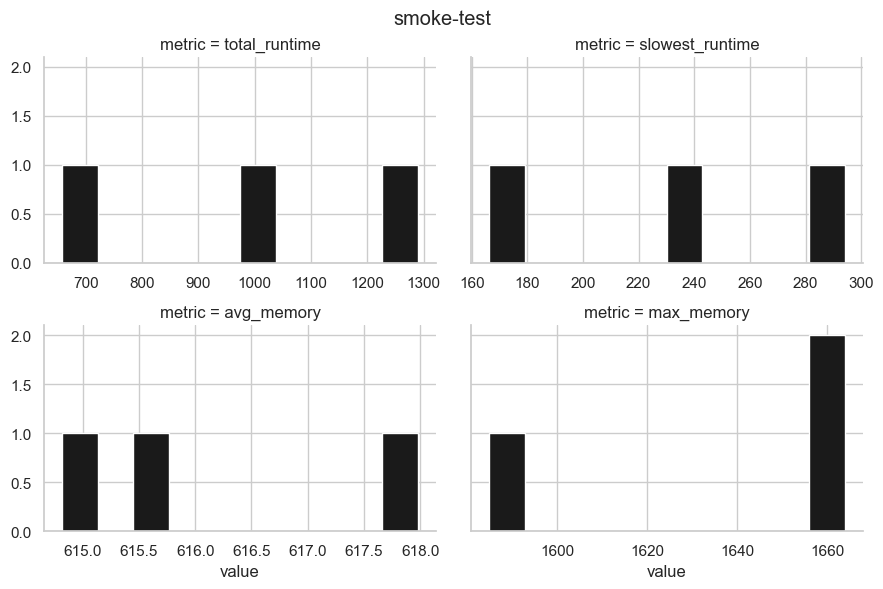

In [13]:
make_histogram(time_series_data_long, "smoke-test")

# Per-tutorial time series plots and histograms

In [14]:
# time series, one tutorial at a time
def make_per_tutorial_ts_plot(mode: str):
    idx = df["ran_successfully"] & (df["mode"] == mode)
    if not idx.any():
        print(f"No data for {mode}")
        return
    g = sns.FacetGrid(
        data=pd.melt(
            df[idx],
            id_vars=["short_name", "datetime"],
            value_vars=["runtime", "memory_increase"],
            value_name="value",
            var_name="metric"
        ),
        col="metric",
        row="short_name",
        sharey=False,
        aspect=3
    )
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.map(plt.plot, "datetime", "value", color="k")
    g.map(plt.scatter, "datetime", "value", color="k")

In [15]:
def make_per_tutorial_hist(mode: str):
    idx = df["ran_successfully"] & (df["mode"] == mode)
    if not idx.any():
        print(f"No data for {mode}")
        return
    g = sns.FacetGrid(
        data=pd.melt(
            df[idx],
            id_vars=["short_name", "datetime"],
            value_vars=["runtime", "memory_increase"],
            value_name="value",
            var_name="metric"
        ),
        col="metric",
        row="short_name",
        sharex=False,
        aspect=3
    )
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.map(plt.hist, "value", color="k")

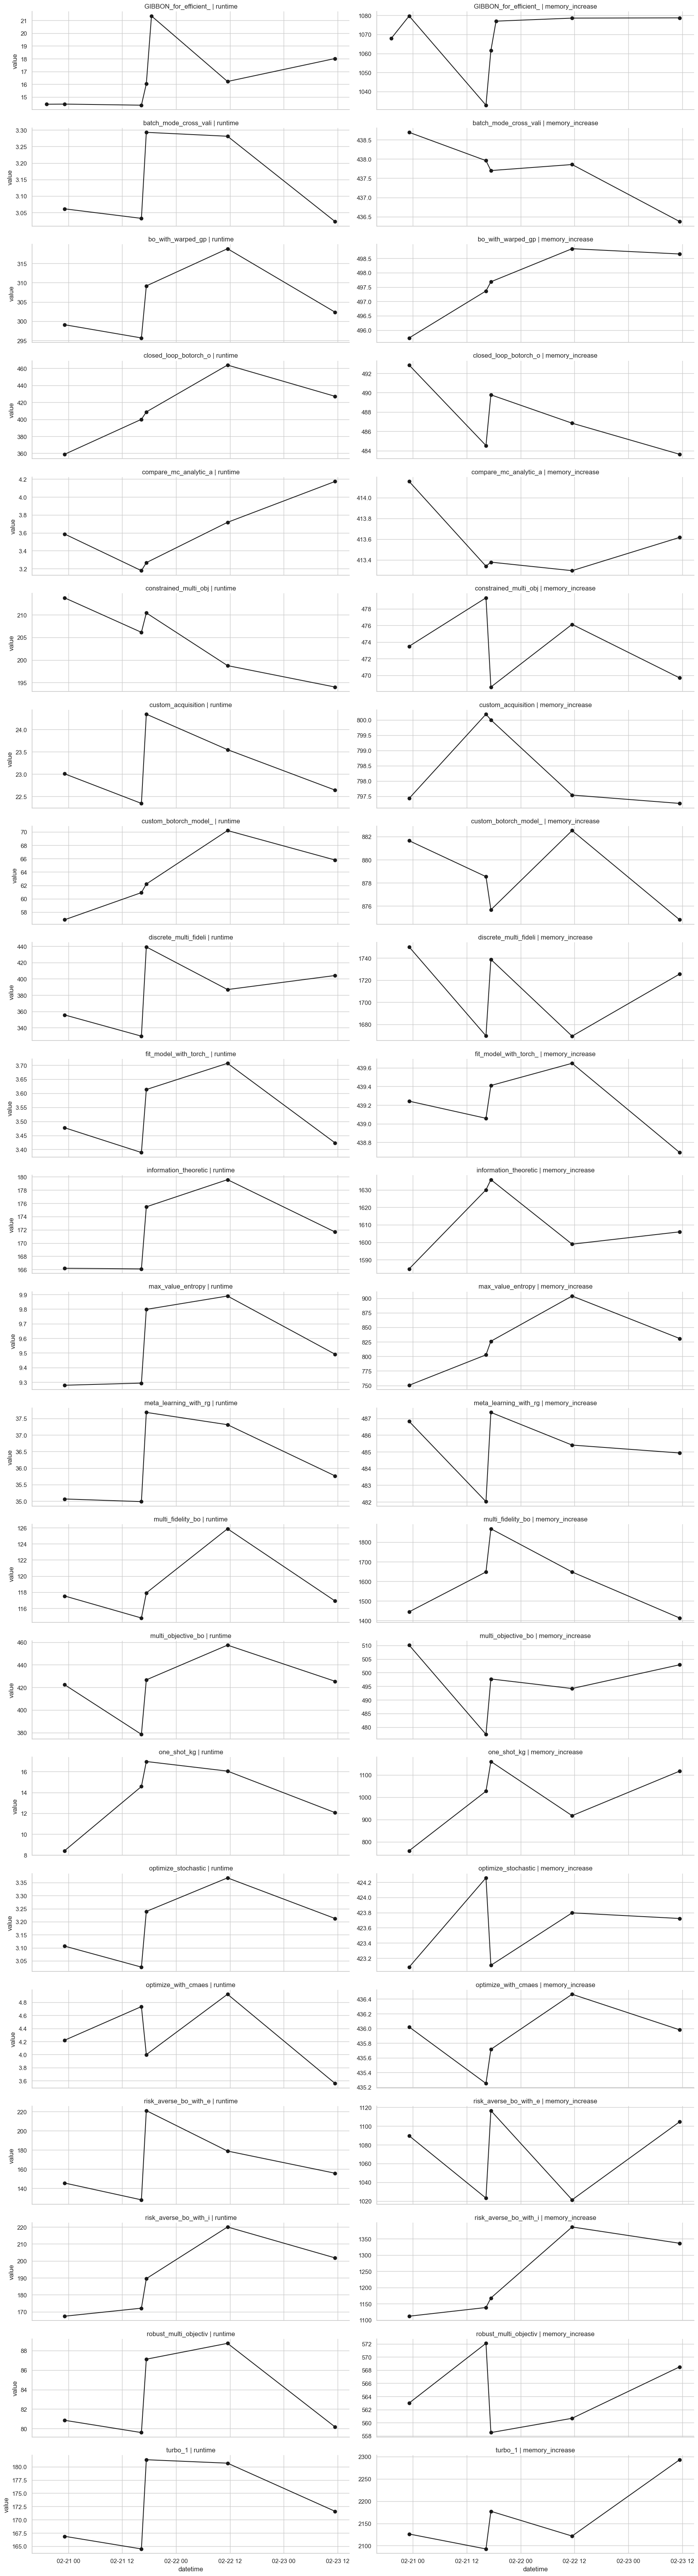

In [16]:
make_per_tutorial_ts_plot("standard")

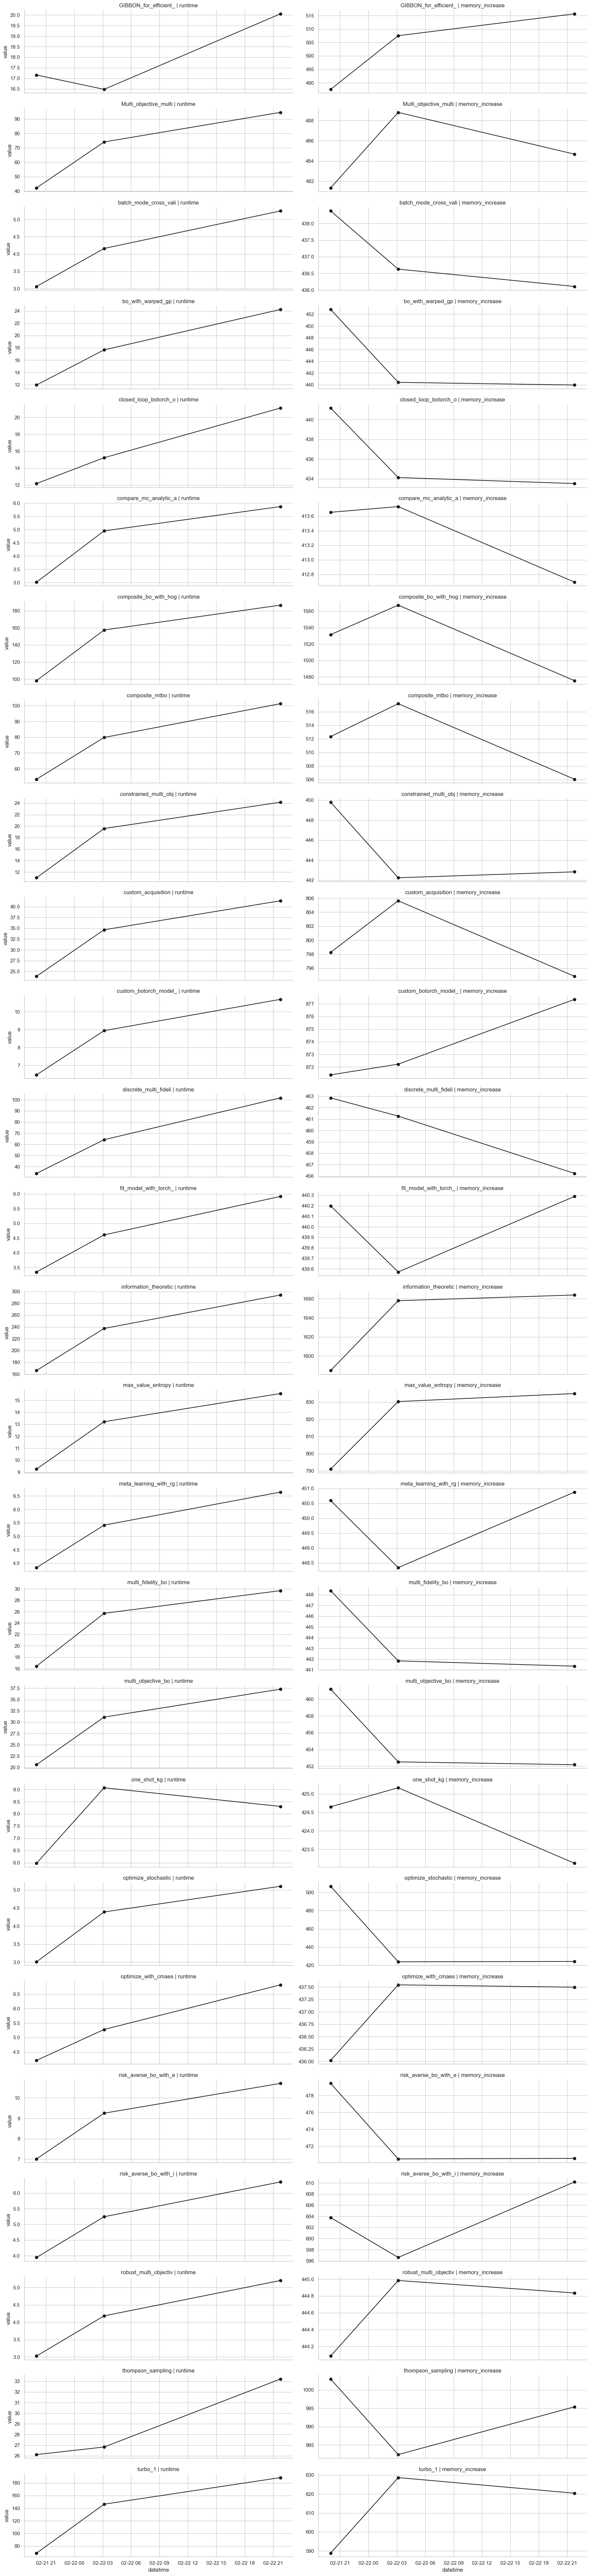

In [17]:
make_per_tutorial_ts_plot("smoke-test")

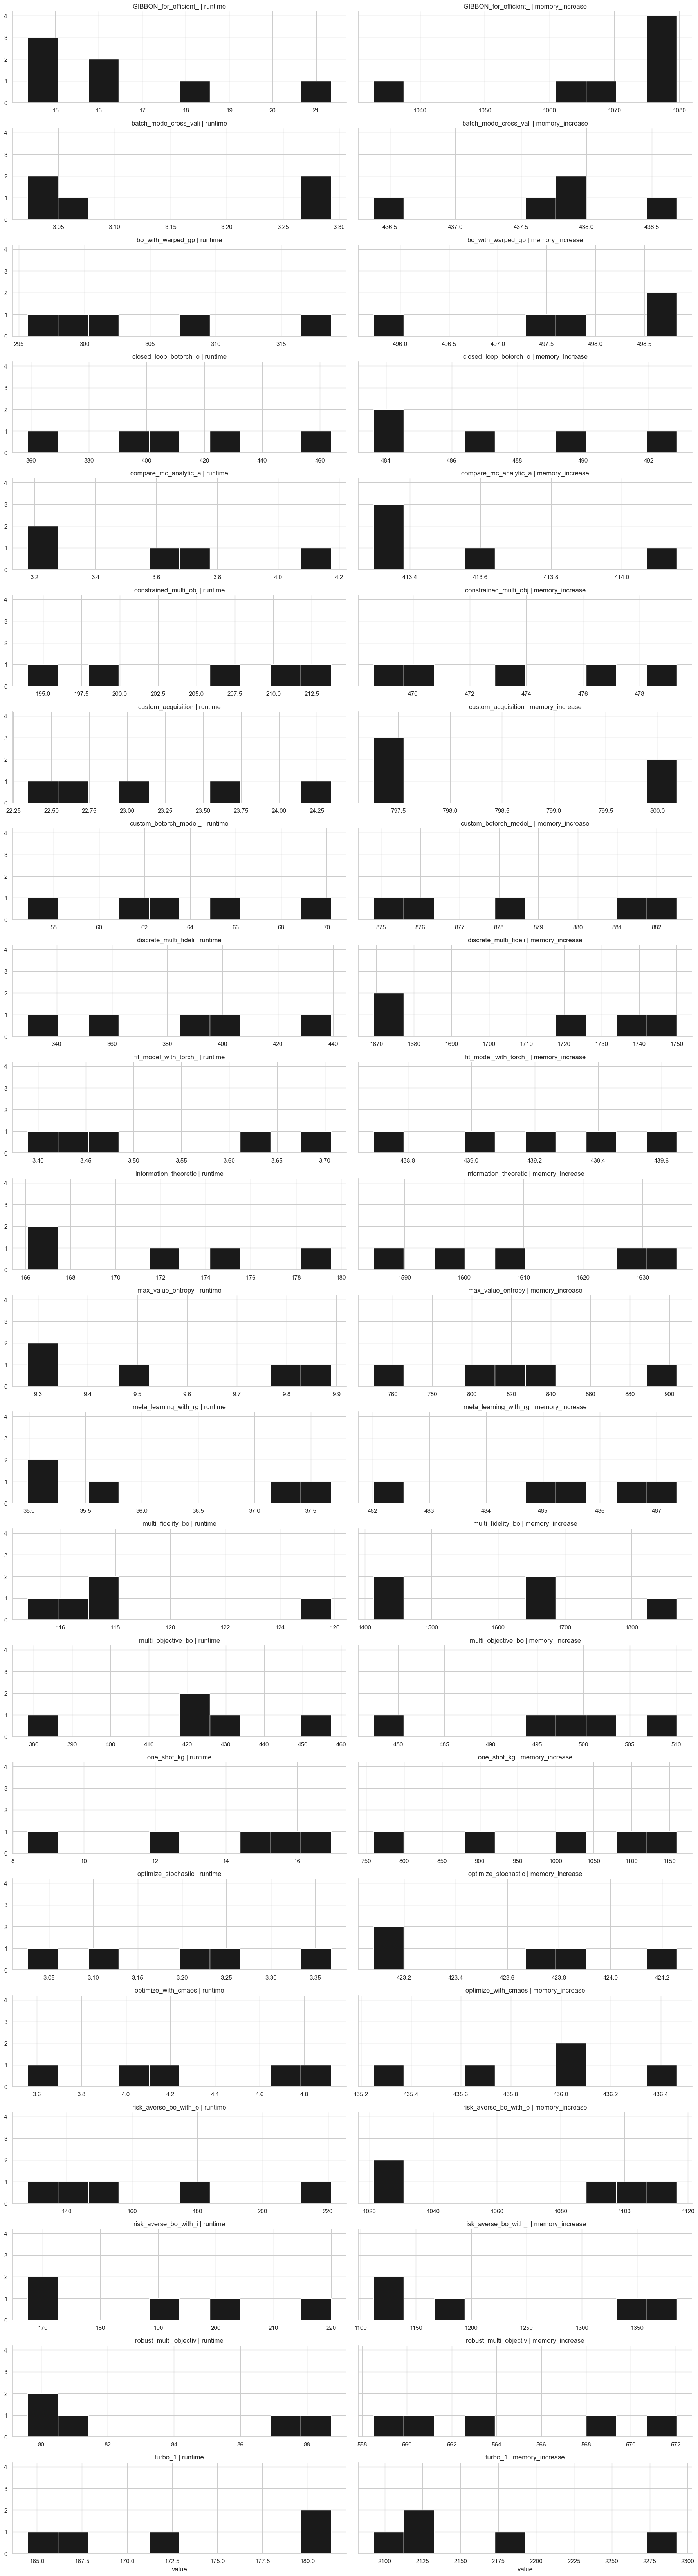

In [18]:
make_per_tutorial_hist("standard")

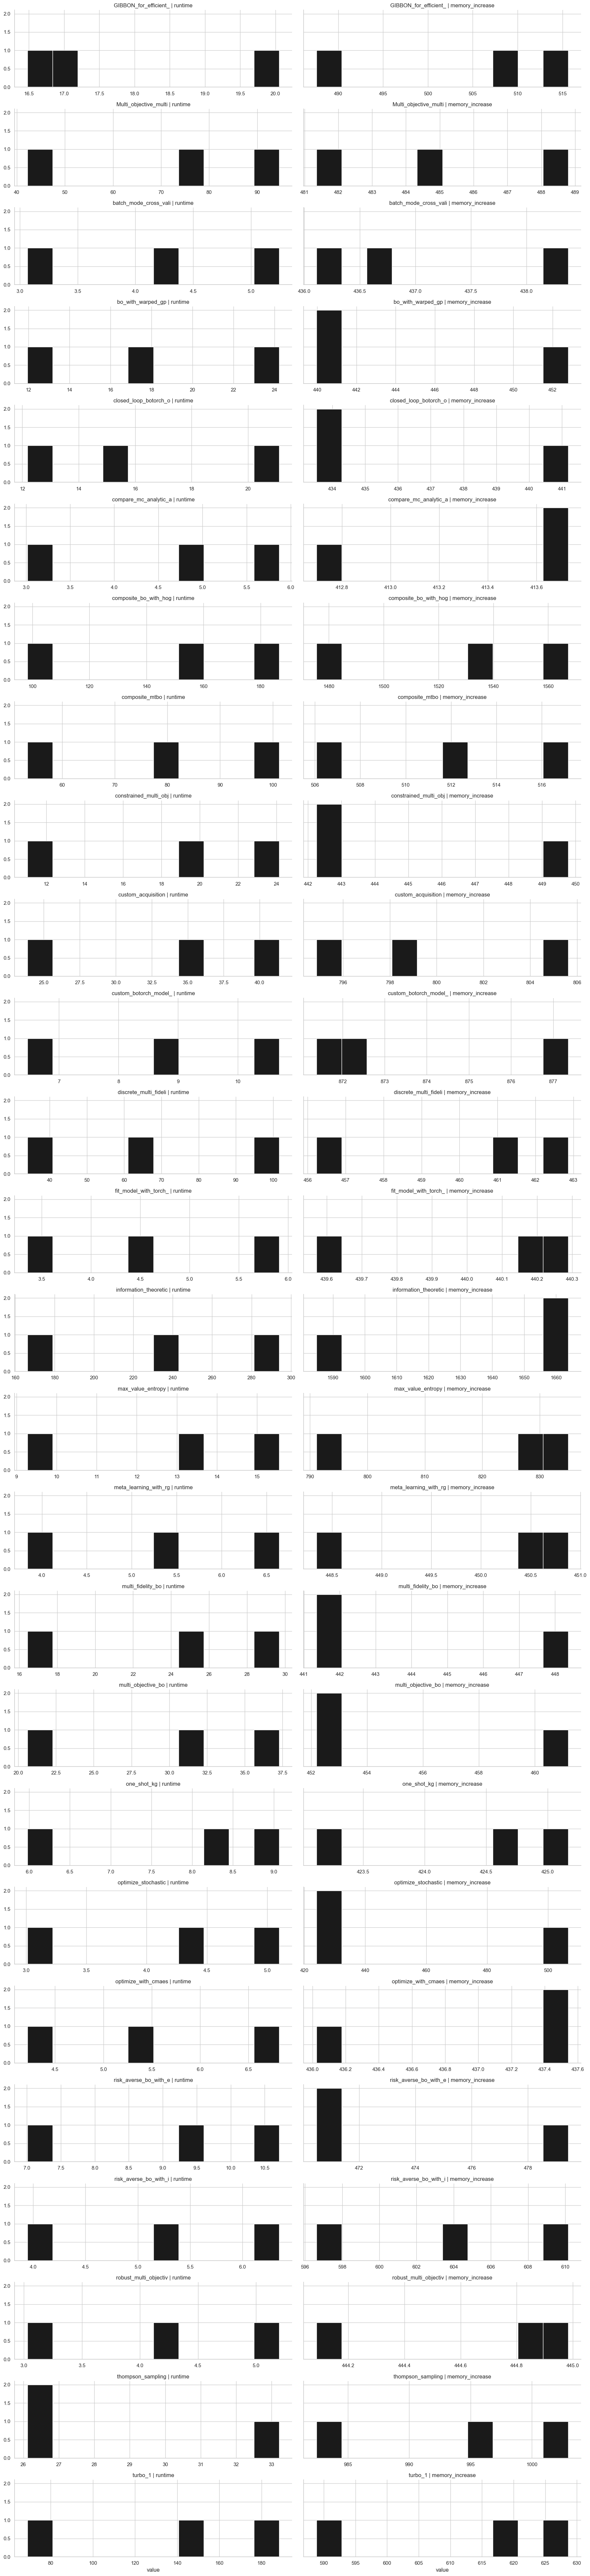

In [19]:
make_per_tutorial_hist("smoke-test")

# Compare tutorials against each other

In [ ]:
last_run_data = df[
    df["datetime"] == df.groupby("mode")["datetime"].transform("max")
].sort_values("memory_increase")
last_run_data_long = pd.melt(
    last_run_data, id_vars=["mode", "name"], value_vars=["runtime", "memory_increase"],
    var_name="metric"
)
last_run_data_long.head()

In [ ]:
g = sns.catplot(
    data=last_run_data_long,
    col="metric",
    row="mode",
    x="value",
    y="name",
    kind="bar",
    orient="h",
    sharex=False,
    color="k"
)
g.fig.suptitle("Metrics on the most recent run in this mode")
plt.subplots_adjust(top=0.9)